## Final Project Code for Data Parsing and SVM, RF, NB classifiers

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk

from os import listdir
from os.path import isfile, join
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from timeit import default_timer as timer
# needed to see images
from IPython.display import display, Image

# Config the matlotlib backend as plotting inline in IPython
#%matplotlib inline
import time
import pickle
import seaborn as sns
import librosa
current_palette = sns.color_palette()

In [2]:
raw_sound = pd.read_csv('UrbanSound8K_HF1030/metadata/UrbanSound8K.csv')
raw_sound.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
import soundfile as sf
data, samplerate = sf.read('UrbanSound8K_HF1030/audio/fold1/102106-3-0-0.wav')
print(data, samplerate)

[[-0.01174927  0.03039551]
 [-0.01153564  0.02471924]
 [-0.01644897  0.01794434]
 ...
 [-0.00588989  0.00012207]
 [ 0.00314331  0.00585938]
 [ 0.00540161  0.00689697]] 44100


In [4]:
fold_list = []
for i in range(1,11):
    fold_name = 'fold' + str(i)
    fold_list.append(fold_name)
print(fold_list)

['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']


In [7]:
'''Set parameters'''
n_mfcc = 40
hop_length = 512
# nfft defaults 2048 in librosa
n_mels = 40

In [8]:
def extract_feature(file_name):
    """
    Extracts 193 chromatographic features from sound file. 
    including: MFCC's, Chroma_StFt, Melspectrogram, Spectral Contrast, and Tonnetz
    NOTE: this extraction technique changes the time series nature of the data
    """
    X, sample_rate = librosa.load(file_name,sr=None)
    X_22050, sam_rate_22050 = librosa.load(file_name)
    stft_22050 = np.abs(librosa.stft(X_22050))
    stft = np.abs(librosa.stft(X))
    
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length, n_mels=n_mels).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft_22050, sr=sam_rate_22050).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X_22050), sr=sam_rate_22050).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

In [10]:
#a,b,c,d,e = extract_feature('UrbanSound8K_HF1030/audio/fold1/99180-9-0-0.wav')
start_time = timer()
a,b,c,d,e = extract_feature('UrbanSound8K_HF1030/audio/fold1/99180-9-0-0.wav')
end_time = timer()
print('time to extract features from one file: {:.3f}sec'.format((end_time-start_time)/60))

time to extract features from one file: 0.006sec


In [11]:
num_features = a.shape[0] +b.shape[0] +c.shape[0] +d.shape[0] +e.shape[0]
print(a.shape,b.shape,c.shape,d.shape,e.shape)
print(a[0])
print(num_features)

(40,) (12,) (128,) (7,) (6,)
-100.7343373680647
193


In [14]:
mfcc_data = []
exception_count = 0

start_time = timer()
for i in range(10):
    # get file names
    mypath = 'UrbanSound8K_HF1030/audio/'+ fold_list[i] + '/'
    files = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]
    
    for fn in files:
        try: # extract features
            mfccs,chroma,mel,contrast,tonnetz = extract_feature(fn)
            features = np.empty((0,num_features))
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            
        except:
            print(fn)
            exception_count += 1
            continue

   #     l_row = raw_sound.loc[raw_sound['slice_file_name']==fn].values.tolist()
        l_row = raw_sound.loc[raw_sound['slice_file_name']==fn.split('/')[-1]].values.tolist()
        label = l_row[0][-1]
        class_id = l_row[0][-2]
        fold = i+1
    
        mfcc_data.append([features, features.shape, class_id, label, fold])
        
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exception_count)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))

/home/fjtsai/.local/lib/python3.5/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


UrbanSound8K_HF1030/audio/fold1/.DS_Store


/home/fjtsai/.local/lib/python3.5/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


UrbanSound8K_HF1030/audio/fold2/.DS_Store


/home/fjtsai/.local/lib/python3.5/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


UrbanSound8K_HF1030/audio/fold3/.DS_Store


/home/fjtsai/.local/lib/python3.5/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


UrbanSound8K_HF1030/audio/fold4/.DS_Store


/home/fjtsai/.local/lib/python3.5/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


UrbanSound8K_HF1030/audio/fold5/.DS_Store


/home/fjtsai/.local/lib/python3.5/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


UrbanSound8K_HF1030/audio/fold6/.DS_Store


/home/fjtsai/.local/lib/python3.5/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


UrbanSound8K_HF1030/audio/fold7/.DS_Store


/home/fjtsai/.local/lib/python3.5/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/fjtsai/.local/lib/python3.5/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


UrbanSound8K_HF1030/audio/fold8/.DS_Store


/home/fjtsai/.local/lib/python3.5/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


UrbanSound8K_HF1030/audio/fold9/.DS_Store
UrbanSound8K_HF1030/audio/fold10/.DS_Store
Exceptions:  10
time taken: 72.0 minutes 37.1 seconds
None


In [15]:
pickle.dump(mfcc_data, open('MFCCforML_1031.p', 'wb'))

In [ ]:
#mfcc_pd = pickle.load(open('feature_data1.p',"rb"))

In [16]:
cols=["features", "shape","label_id", "label", "fold"]
mfcc_data = pd.DataFrame(data = mfcc_data, columns=cols)

In [17]:
mfcc_data.head()

,features,shape,label_id,label,fold
0,"[[-105.06212476278826, 58.2669207690394, -4.19...","(1, 193)",5,engine_idling,1
1,"[[-124.45740140108683, 127.51212095331138, -29...","(1, 193)",7,jackhammer,1
2,"[[-219.55987652950563, 109.651516031176, -14.0...","(1, 193)",9,street_music,1
3,"[[-132.4537100734293, 127.67266663126416, -28....","(1, 193)",7,jackhammer,1
4,"[[-50.480787298730924, 94.33832870986032, -48....","(1, 193)",7,jackhammer,1


In [18]:
labels = set(mfcc_data['label'])
print(labels)
cnt = [[label,list(mfcc_data['label']).count(label)] for label in labels]
dict_cnt = dict(cnt)
dict_cnt

{'air_conditioner', 'car_horn', 'dog_bark', 'jackhammer', 'street_music', 'siren', 'gun_shot', 'engine_idling', 'children_playing', 'drilling'}


{'air_conditioner': 1000,
 'car_horn': 424,
 'children_playing': 1000,
 'dog_bark': 1000,
 'drilling': 1000,
 'engine_idling': 1000,
 'gun_shot': 374,
 'jackhammer': 1000,
 'siren': 929,
 'street_music': 1000}

In [19]:
cnt_cols=["classes","occurence"]
count_pd = pd.DataFrame(data = cnt, columns=cnt_cols)

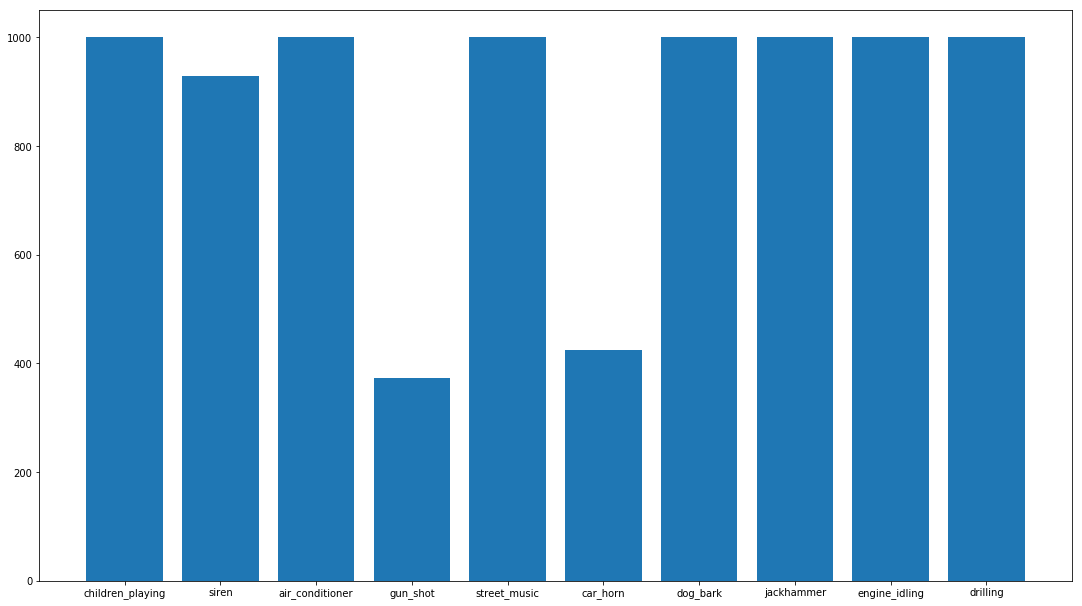

In [24]:
#dictionary = plt.figure()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

fig.set_size_inches(18.5, 10.5, forward=True)
plt.bar(range(len(dict_cnt)), list(dict_cnt.values()), align='center')
plt.xticks(range(len(dict_cnt)), dict_cnt.keys())
plt.show()
#plot_url = py.plot_mpl(dictionary, filename='mpl-dictionary')


In [25]:
labels = set(mfcc_data['label_id'])
mapping = []
for label_id in labels:
    
    label_name = set(mfcc_data.loc[mfcc_data['label_id'] == label_id]['label'])
    mapping.append((label_id,label_name))
label_mapping = dict(mapping)
label_mapping

{0: {'air_conditioner'},
 1: {'car_horn'},
 2: {'children_playing'},
 3: {'dog_bark'},
 4: {'drilling'},
 5: {'engine_idling'},
 6: {'gun_shot'},
 7: {'jackhammer'},
 8: {'siren'},
 9: {'street_music'}}

In [27]:
ll = [mfcc_data['features'][i].ravel() for i in range(mfcc_data.shape[0])]
mfcc_data['sample'] = pd.Series(ll, index=mfcc_data.index)
del mfcc_data['features']
mfcc_data.head()

,shape,label_id,label,fold,sample
0,"(1, 193)",5,engine_idling,1,"[-105.06212476278826, 58.2669207690394, -4.194..."
1,"(1, 193)",7,jackhammer,1,"[-124.45740140108683, 127.51212095331138, -29...."
2,"(1, 193)",9,street_music,1,"[-219.55987652950563, 109.651516031176, -14.03..."
3,"(1, 193)",7,jackhammer,1,"[-132.4537100734293, 127.67266663126416, -28.6..."
4,"(1, 193)",7,jackhammer,1,"[-50.480787298730924, 94.33832870986032, -48.5..."


In [ ]:
#http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
#http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

## Random Forest Classifier

In [28]:
# Random Forest classifier. Use fold10 as test set. Use fold1-9 for 9-fold cross validation
forest = OneVsRestClassifier(RandomForestClassifier(n_estimators = 500, max_depth=20, min_samples_leaf=30))

In [29]:
train_data = np.array(list(mfcc_data.loc[mfcc_data['fold'] < 9]['sample']))
train_label = np.array(mfcc_data.loc[mfcc_data['fold'] < 9]['label_id'])
validation_data = np.array(list(mfcc_data.loc[mfcc_data['fold'] == 9]['sample']))
validation_label = np.array(mfcc_data.loc[mfcc_data['fold'] == 9]['label_id'])
#test_data = np.array(list(mfcc_data.loc[mfcc_data['fold'] == 10]['sample']))
#test_label = np.array(mfcc_data.loc[mfcc_data['fold'] == 10]['label_id'])

In [30]:
print(train_data.shape)
print(type(train_data))

(7074, 193)
<class 'numpy.ndarray'>


In [31]:
np.mean(train_data[0])

0.8910186665384765

In [32]:
forestmodel = forest.fit(train_data, train_label)

In [33]:
prediction = forestmodel.predict(validation_data)

In [34]:
prob_pred = forestmodel.predict_proba(validation_data)

In [35]:
prob_pred[0]

array([0.07899789, 0.00525792, 0.4091391 , 0.17137861, 0.03946094,
       0.02419535, 0.02545686, 0.0216304 , 0.04156364, 0.18291929])

In [38]:
forest_accuracy = np.sum(prediction == validation_label)/validation_label.shape[0]
#svc_accuracy = np.sum(svc_prediction == validation_label)/validation_label.shape[0]
forest_accuracy

0.6115196078431373

In [39]:
def confusion(true, predicted):
    matrix = np.zeros([10,10])
    #d = 0
    for t, p in zip(true, predicted):
        matrix[t,p] += 1.5
    #    d += 1
    #print(d)
    return matrix

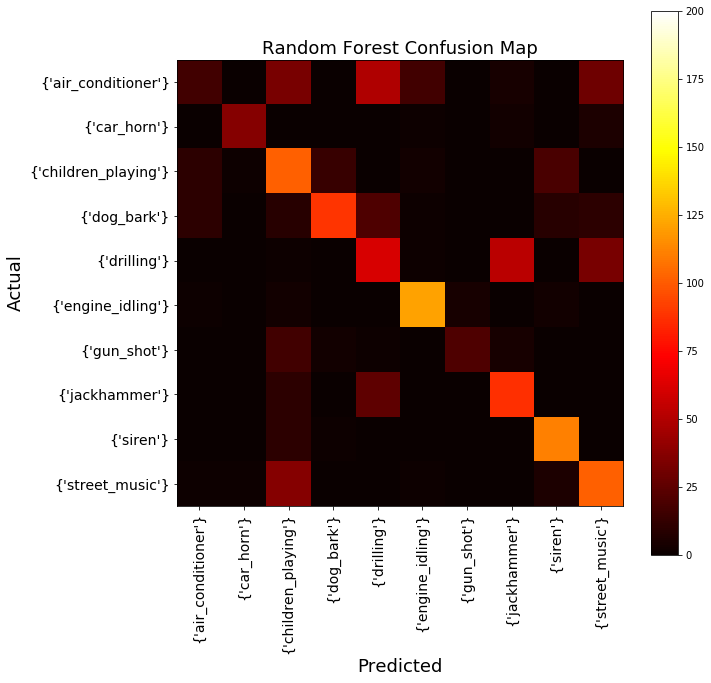

In [40]:
classe_names = label_mapping.values()
matrix = confusion(validation_label, prediction)

plt.figure(figsize=[10,10])
plt.imshow(matrix, cmap='hot', interpolation='nearest',  vmin=0, vmax=200)
plt.colorbar()
plt.title('Random Forest Confusion Map', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.grid(b=False)
plt.yticks(range(10), classe_names, fontsize=14)
plt.xticks(range(10), classe_names, fontsize=14, rotation='vertical')
plt.show()

## Support Vector Machien Classifier

In [41]:
from sklearn.svm import NuSVC
from sklearn.svm import SVC

In [42]:
svm = OneVsRestClassifier(NuSVC(nu=.08, kernel='poly', decision_function_shape='ovr'))
svmmodel = svm.fit(train_data, train_label)

/home/fjtsai/.local/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fjtsai/.local/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fjtsai/.local/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fjtsai/.local/lib/python3.5/site-packages/sklearn/svm/base

In [43]:
svc_prediction = svmmodel.predict(validation_data)

In [44]:
svc_accuracy = np.sum(svc_prediction == validation_label)/validation_label.shape[0]
svc_accuracy

0.5968137254901961

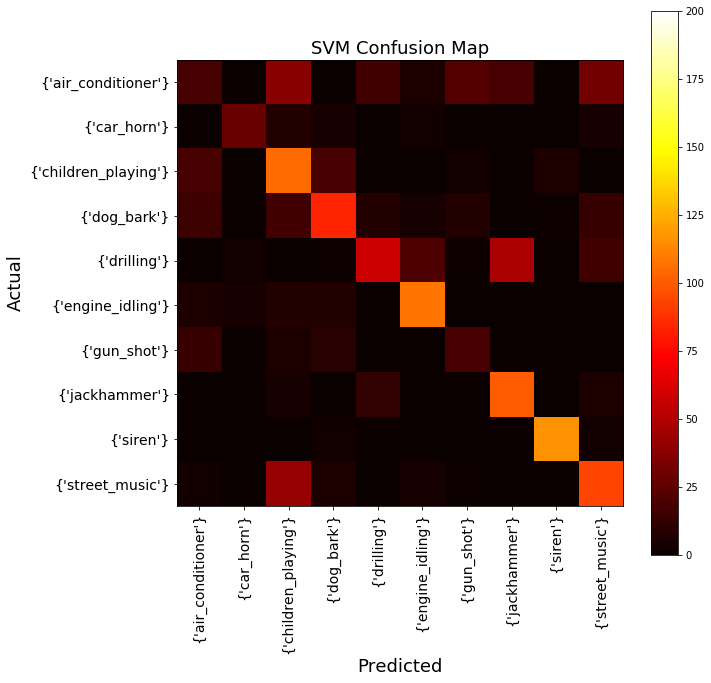

In [45]:
classe_names = label_mapping.values()
matrix = confusion(validation_label, svc_prediction)

plt.figure(figsize=[10,10])
plt.imshow(matrix, cmap='hot', interpolation='nearest',  vmin=0, vmax=200)
plt.colorbar()
plt.title('SVM Confusion Map', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.grid(b=False)
plt.yticks(range(10), classe_names, fontsize=14)
plt.xticks(range(10), classe_names, fontsize=14, rotation='vertical')
plt.show()

## Naive Bayes Classifier

In [46]:
NB = OneVsRestClassifier(GaussianNB())
nbmodel = NB.fit(train_data, train_label)

In [47]:
NB_prediction = nbmodel.predict(validation_data)

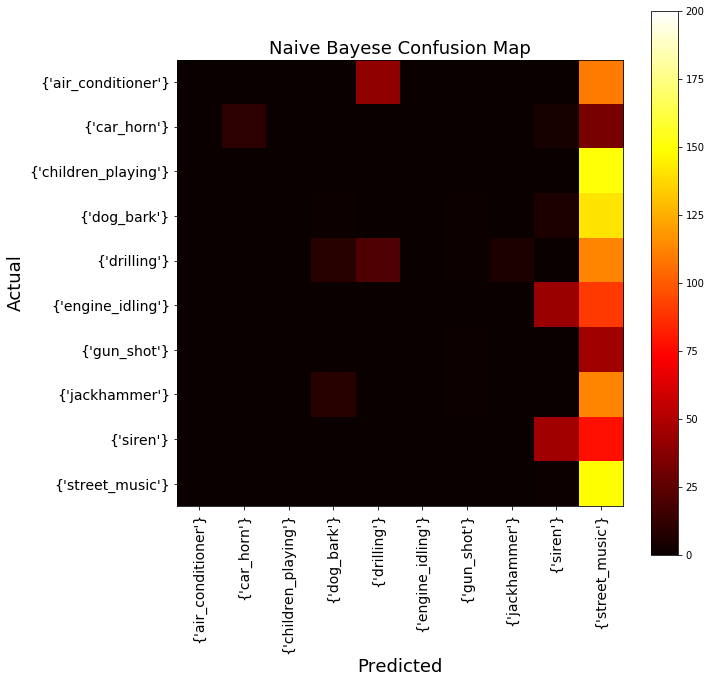

In [48]:
classe_names = label_mapping.values()
matrix = confusion(validation_label, NB_prediction)

plt.figure(figsize=[10,10])
plt.imshow(matrix, cmap='hot', interpolation='nearest',  vmin=0, vmax=200)
plt.colorbar()
plt.title('Naive Bayese Confusion Map', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.grid(b=False)
plt.yticks(range(10), classe_names, fontsize=14)
plt.xticks(range(10), classe_names, fontsize=14, rotation='vertical')
plt.show()

In [49]:
nb_accuracy = np.sum(NB_prediction == validation_label)/validation_label.shape[0]
nb_accuracy

0.18627450980392157

## Visualization

In [ ]:
#Code for Visualization borrowed from : https://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/


from matplotlib.pyplot import specgram
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

#mypath = 'UrbanSound8K/audio/'    
    
sound_file_paths = ["UrbanSound8K_HF1030/audio/fold1/57320-0-0-7.wav","UrbanSound8K_HF1030/audio/fold1/24074-1-0-3.wav",\
                    "UrbanSound8K_HF1030/audio/fold1/15564-2-0-1.wav","UrbanSound8K_HF1030/audio/fold1/31323-3-0-1.wav",\
                    "UrbanSound8K_HF1030/audio/fold1/46669-4-0-35.wav","UrbanSound8K_HF1030/audio/fold1/89948-5-0-0.wav",\
                    "UrbanSound8K_HF1030/audio/fold1/40722-8-0-4.wav","UrbanSound8K_HF1030/audio/fold1/103074-7-3-2.wav",
                    "UrbanSound8K_HF1030/audio/fold1/106905-8-0-0.wav","UrbanSound8K_HF1030/audio/fold1/108041-9-0-4.wav"]


sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]

raw_sounds = load_sound_files(sound_file_paths)

plot_waves(sound_names,raw_sounds)
plot_specgram(sound_names,raw_sounds)
plot_log_power_specgram(sound_names,raw_sounds)